In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, chi2, RFECV, RFE, SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load training data and test data

## 1.1 Read the csv files and get an overview of the data

In [4]:
X_df = pd.read_csv('/content/drive/MyDrive/AML/task1/X_train.csv') # df stands for dataframe
y_df = pd.read_csv('/content/drive/MyDrive/AML/task1/y_train.csv')
X_test_df = pd.read_csv('/content/drive/MyDrive/AML/task1/X_test.csv')
print("Dimension of X: {}".format(X_df.shape))
print("Dimension of y: {}".format(y_df.shape))
X_df.tail()
y_df.tail()

Dimension of X: (1212, 833)
Dimension of y: (1212, 2)


,id,y
1207,1207.0,67.0
1208,1208.0,48.0
1209,1209.0,82.0
1210,1210.0,76.0
1211,1211.0,81.0


## 1.2 Get rid of the id column

In [5]:
X_data = X_df.iloc[:,1:]
y_data = y_df.iloc[:,1:]
X_test = X_test_df.iloc[:, 1:]
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_test shape:", X_test.shape)

X_data shape: (1212, 832)
y_data shape: (1212, 1)
X_test shape: (776, 832)


# 2. Fill the missing values

## 2.1 Get to know how many missing values there are

In [6]:
feature_missing_values = X_data.isna().sum(axis = 0)
print ("Number of missing values for each feature:\n", feature_missing_values)

record_missing_values = X_data.isna().sum(axis = 1)
print ("Number of missing values for each record:\n", record_missing_values)

Number of missing values for each feature:
 x0       94
x1       98
x2       95
x3      106
x4       95
       ... 
x827    103
x828     97
x829    100
x830     88
x831    121
Length: 832, dtype: int64
Number of missing values for each record:
 0       59
1       67
2       61
3       57
4       62
        ..
1207    55
1208    76
1209    60
1210    51
1211    69
Length: 1212, dtype: int64


## 2.2 Using median

In [7]:
# X_data_1 = X_data.fillna(X_data.median())
# X_test_1 = X_test.fillna(X_test.median())
# missing_values = X_data_1.isna().any() # any(): Return whether any element is True, potentially over an axis.
# print ("After filling, number of missing values for each feature:\n", missing_values)

## 2.3 Using KNN

In [8]:
# To use KNN imputer, we need to first normalize our data so the distance measure of each feature is the same
scaler = RobustScaler(quantile_range=(10, 90))
X_data_sc = pd.DataFrame(scaler.fit_transform(X_data), columns=X_data.columns)
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

imputer = KNNImputer(n_neighbors=5)
X_data_1 = pd.DataFrame(imputer.fit_transform(X_data_sc), columns=X_data.columns)
X_test_1 = pd.DataFrame(imputer.fit_transform(X_test_sc), columns=X_test.columns)

print("Missing values", X_data_1.isna().any())

Missing values x0      False
x1      False
x2      False
x3      False
x4      False
        ...  
x827    False
x828    False
x829    False
x830    False
x831    False
Length: 832, dtype: bool


# 3. Outlier detection

## 3.1 Using IsolationForest

In [9]:
iso_forest = IsolationForest(n_estimators=500, contamination=0.05)
iso_forest = iso_forest.fit(X_data_1)
isof_outliers = iso_forest.predict(X_data_1)
X_data_2 = X_data_1.iloc[isof_outliers == 1, :]
y_data = y_data.iloc[isof_outliers == 1].values
print(X_data_2.shape)

X_test_2 = X_test_1

# # Delete nothing
# X_data_2 = X_data_1
# X_test_2 = X_test_1
# y_data = y_data.values

(1151, 832)


In [10]:
X_data_2.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x792,x793,x794,x795,x796,x797,x798,x799,x800,x801,x802,x803,x804,x805,x806,x807,x808,x809,x810,x811,x812,x813,x814,x815,x816,x817,x818,x819,x820,x821,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,0.366254,-0.602537,0.237168,-0.246672,0.646918,-0.356928,0.614377,-0.332445,0.563801,-0.302874,-0.498416,0.212626,-0.484550,-0.230231,-0.443511,0.323738,0.527316,-0.560667,-0.057300,-0.398784,0.331705,0.936314,0.139309,0.166117,-0.120616,-0.483488,-0.133835,-0.379148,-0.522631,0.185912,-0.310709,0.401079,-0.058608,-0.065739,0.219344,0.338877,-0.521471,-0.050881,0.821375,-0.206204,...,0.091529,0.354864,-0.000498,-0.166341,0.104771,-0.160049,0.537924,0.637074,-0.044632,0.357295,0.120632,-0.733933,0.301748,-0.519026,0.151594,-0.355137,0.804673,-0.037777,0.380540,0.172868,-0.507662,0.038349,-0.128503,-0.033035,0.065428,-0.471241,0.332334,-0.192552,0.210712,0.117579,-0.318885,0.050707,-0.196689,0.117974,0.325079,0.303604,-0.566476,-0.176145,-0.575897,-0.226159
2,0.432092,0.458436,-0.147386,-0.553701,-0.306695,-0.351380,-0.038824,0.109042,0.104857,-0.026660,0.175691,-0.213002,-0.400969,-0.706979,0.123232,0.132832,-0.571213,-0.142955,-0.208848,0.056125,0.031362,0.392277,-0.206804,-1.281982,0.533658,0.041791,0.163144,0.296507,-0.104647,0.064881,0.664561,-0.462420,0.311602,-0.083953,0.057019,-0.313337,0.181062,-0.149937,-0.080653,-0.422615,...,0.930956,-0.404625,-0.626460,0.177020,-0.144440,-0.184671,-0.553214,-0.199383,0.067927,-0.024507,-0.071273,-0.179701,-0.572265,-0.311823,-0.208124,0.152407,-0.187030,-0.347608,0.176291,-0.144937,0.297918,0.077217,0.084467,-0.432927,-0.368816,-0.022950,0.410962,0.504689,0.473242,-0.125366,-0.390869,-0.080001,-0.400141,0.271402,0.092331,-0.731324,0.275481,-0.381353,-0.778377,-0.086109
4,0.167169,-0.361734,0.396267,-0.238947,-0.019179,-0.669567,-0.078957,0.639629,0.244143,-0.432669,0.592228,0.613683,0.515475,-0.628716,0.455264,0.355937,-0.585780,-0.062891,0.372641,0.254074,-0.154041,-0.327385,0.073526,0.140675,0.011798,-0.146518,-0.484218,0.285343,0.736146,0.557712,0.024150,-0.578573,0.268679,-0.344200,0.603555,0.328378,-0.417409,-0.164655,0.181360,0.822299,...,-0.005846,0.111864,0.428670,0.284042,0.409506,0.331444,0.453075,-0.334999,0.063464,0.487918,-0.103585,0.208841,-0.609823,-0.486181,-0.146785,0.430425,-0.408727,0.660101,0.437674,0.221476,-0.279948,0.966123,-0.044372,0.514427,-0.734786,-0.081034,0.355136,0.088157,-0.825760,-0.216536,-0.232344,-0.380367,0.835558,0.049827,0.099136,0.321395,0.096218,-0.320239,0.080176,0.040857
5,-0.351395,0.289232,0.293071,-0.062916,0.311761,0.080699,0.063625,-0.139039,-0.100231,0.288177,0.384312,0.269270,0.249566,0.822805,-0.000842,0.574645,-0.094707,0.411075,-0.286924,-0.165425,0.175779,-0.609105,0.714758,-0.210875,0.104949,0.039135,0.280088,0.179142,-0.102233,-0.585132,-0.246189,0.467543,-0.401984,0.312369,-0.173118,0.057036,0.127081,-0.392826,-0.084236,-0.082451,...,-0.144195,-0.420541,0.516235,-0.184277,-0.147865,0.208632,-0.180598,-0.184437,0.017012,-0.357609,-0.045442,-0.037543,0.173530,-0.061712,-0.401402,0.534702,-0.702003,0.322825,0.134834,0.012196,0.369852,0.682798,-0.024586,0.559903,0.846660,-0.513810,-0.317874,-0.096279,0.043405,0.098081,-0.369659,0.215428,-0.085858,0.009466,0.110210,0.321365,0.404988,-0.001046,-0.372933,0.545064
6,-0.042825,-0.546083,0.238445,-0.584761,-0.027881,0.074732,0.082182,0.439288,-0.187196,0.559747,0.650666,0.452827,0.471855,-0.413128,0.290864,-0.179733,-0.260738,-0.019663,-0.040849,-0.371956,-0.245471,0.418760,0.957861,-0.375566,-0.341911,0.102844,-0.428553,0.590769,-0.052330,0.450305,0.191042,-0.205598,0.016183,0.367967,0.325781,0.362794,-0.556797,0.112994,0.464433,0.159660,...,0.276868,-0.192429,0.479095,-0.490182,-0.047360,0.195639,0.449680,-0.357008,0.268580,-0.383713,-0.233643,0.471439,-0.463445,-0.179418,-0.450622,-0.113225,0.236259,-0.162548,0.408056,0.338547,0.2558

# 4. Feature selection

In [16]:
from xgboost import XGBRegressor
from numpy.random import randint
randomNumber = randint(100000000)
XGB_reg = XGBRegressor(n_jobs=-1, objective ='reg:squarederror', 
    n_estimator=100, learning_rate=0.1,subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2,
    reg_lambda=0.2, gamma=0.1, random_state=randomNumber)


In [ ]:
XGB_reg_fit = XGB_reg.fit(X_data_2, y_data)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# feature importance
plt.hist(np.abs(XGB_reg.feature_importances_))

XGBoostError: ignored

In [ ]:
from sklearn.feature_selection import SelectFromModel
threshold=0.003
XGB_reg_sfm = SelectFromModel(XGB_reg, threshold=threshold).fit(X_data_2, y_data)
X_data_3 = XGB_reg_sfm.transform(X_data_2)
X_test_3 = XGB_reg_sfm.transform(X_test_1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data_3, y_data, test_size=0.2, random_state=1)
print("X_train shape: ", X_train.shape)

# 5. Model Selection

In [11]:
X_data_3 = pd.read_csv('/content/drive/MyDrive/AML/task1/RandomForest_features_train.csv') # df stands for dataframe
y_data = pd.read_csv('/content/drive/MyDrive/AML/task1/RandomForest_target_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/AML/task1/RandomForest_features_test.csv')

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data_3, y_data, test_size=0.2, random_state=1)
print("X_train shape: ", X_train.shape)

X_train shape:  (959, 70)


## XGB

In [17]:
XGB_reg_fit = XGB_reg.fit(X_train, y_train)
y_pred = XGB_reg.predict(X_valid)
r_score = r2_score(y_valid, y_pred)
print("Validation score:", r_score)

Validation score: 0.6206238446419607


## ANN

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras import regularizers
# fix random seed for reproducibility

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [20]:
dropout=0.1

model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1], kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(30, input_dim=72, kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(30, input_dim=72, kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(30, input_dim=72, kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(30, input_dim=72, kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(30, input_dim=72, kernel_regularizer = regularizers.l2(1), kernel_initializer='he_uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))

model.add(Dense(1, kernel_initializer='he_uniform'))
# Compile model
opt = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=[coeff_determination])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                2130      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30)                0         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30)                0         
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                9

In [ ]:
# Fit the model
history = model.fit(X_data_3, y_data, epochs=80, verbose=2, validation_split=0.1,
                    shuffle=True, steps_per_epoch=60, initial_epoch=0, validation_steps=5)

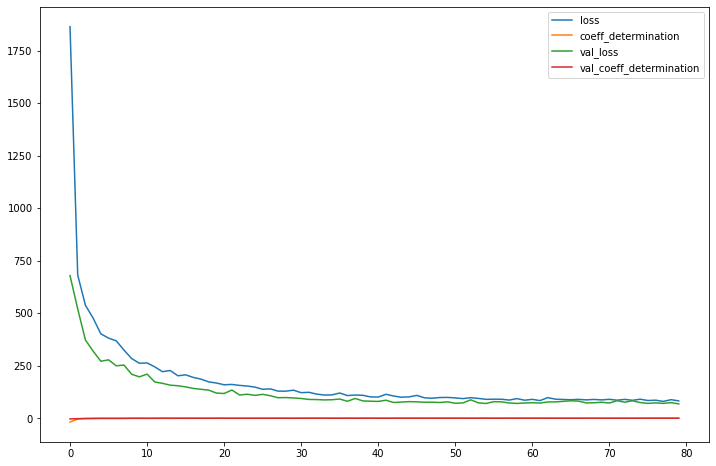

In [23]:
pd.DataFrame(history.history).plot(figsize=(12, 8))

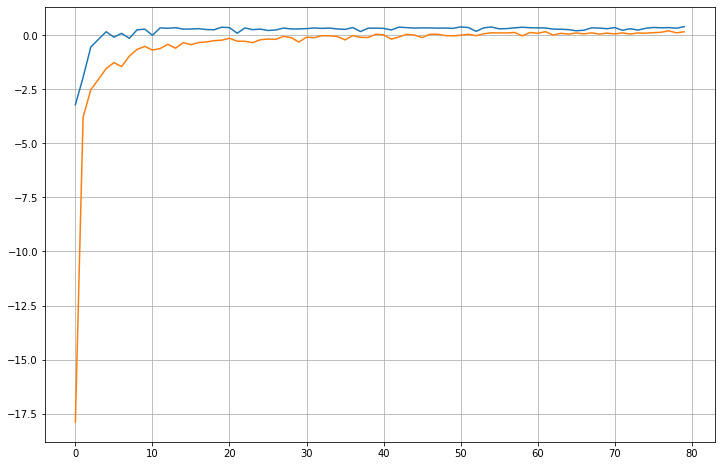

In [24]:
data = pd.DataFrame(history.history)
data["val_coeff_determination"].plot(figsize=(12, 8))
data["coeff_determination"].plot(figsize=(12, 8))
plt.grid(True)

In [25]:
y_pred = model.predict(X_valid)
r_score = r2_score(y_valid, y_pred)
print("Validation score:", r_score)

Validation score: 0.5321526006473909


## 5.1 KernelRidgeRegression
Not good at all. Best score ~0.2

In [ ]:
# model = KernelRidge()
# parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 3.0, 5.0], 'kernel':['chi2', 'rbf', 'sigmoid', 'laplacian'], 'gamma':[0.1, 1, 5, 10]}
# grid = GridSearchCV(model, parameters, scoring='r2', cv=5, verbose=3, n_jobs=-1)
# grid.fit(X_train, y_train.ravel())
# print(grid.best_estimator_)
# print(grid.best_score_)

# y_pred = grid.predict(X_valid)
# r_score = r2_score(y_valid, y_pred)
# print("Validation score:", r_score)

## 5.2 ExtraTreesRegression

In [ ]:
# model = ExtraTreesRegressor()
# parameters = {'n_estimators':[100, 125, 150, 175, 200, 300, 325, 350,400], 'min_samples_split':[2, 3, 4]}
# grid = GridSearchCV(model, parameters, scoring='r2', cv=5, verbose=3, n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_estimator_)
# print(grid.best_score_)

# y_pred = grid.predict(X_valid)
# r_score = r2_score(y_valid, y_pred)
# print("Validation score:", r_score)

## 5.3 RandomForestRegression

In [ ]:
model = RandomForestRegressor()
parameters = {'n_estimators':[200, 300, 325, 350, 400, 430, 450, 500], 'min_samples_split':[2, 3, 4, 5]}
grid = GridSearchCV(model, parameters, scoring='r2', verbose=1, cv=5, n_jobs=-1)
grid.fit(X_train, y_train.ravel())
print(grid.best_estimator_)
print(grid.best_score_)

y_pred = grid.predict(X_valid)
r_score = r2_score(y_valid, y_pred)
print("Validation score:", r_score)


In [ ]:
# estimator2 = grid.best_estimator_
# selector2 = SelectFromModel(estimator2, max_features=150, threshold="mean")
# selector2 = selector2.fit(X_data_2, y_data.ravel())
# X_data_3 = selector2.transform(X_data_2)
# X_test_3 = selector2.transform(X_test_2)

# X_train, X_valid, y_train, y_valid = train_test_split(X_data_3, y_data, test_size=0.2, random_state=1)
# print("X_train shape: ", X_train.shape)

# rfr = estimator2.fit(X_train, y_train.ravel())
# y_pred = rfr.predict(X_valid)
# r_score = r2_score(y_valid,y_pred)
# print("Validation score:", r_score)


In [ ]:
rfr = estimator.fit(X_train, y_train)
y_pred = rfr.predict(X_valid)
r_score = r2_score(y_valid,y_pred)
print("Validation score:", r_score)

## 5.4 SupportVectorRegression
score ~ 0.5

In [ ]:
# model = SVR()
# parameters = {'kernel':['sigmoid', 'rbf', 'poly'], 'degree':[3, 4, 5, 7, 9], 'gamma':[0.005, 0.01, 0.05, 0.1, 1], 'C':[0.01, 0.05, 0.1, 1, 2]}
# grid = GridSearchCV(model, parameters, scoring='r2', cv=5, verbose=1, n_jobs=8)
# grid.fit(X_train, y_train.ravel())
# print(grid.best_estimator_)
# print(grid.best_score_)

# y_pred = grid.predict(X_valid)
# r_score = r2_score(y_valid, y_pred)
# print("Validation score:", r_score)

# 6. Export the prediction

In [29]:
# rfr = grid.best_estimator_

y_test = model.predict(X_test)
data_id = X_df['id']
result = list(zip(data_id,y_test))
result_table = pd.DataFrame(data = result, columns = ['id', 'y'])
result_table.tail()
result_table.to_csv('ann.csv', index = False)